In [2]:
%pip install pillow
%pip install -U "ibm_watsonx_ai>=1.1.14"

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
#imports
import requests
import base64
import getpass

from PIL import Image
from ibm_watsonx_ai import Credentials
from ibm_watsonx_ai.foundation_models import ModelInference

In [4]:
WATSONX_EU_APIKEY = ("KzVEd15JglyLkmlMgJxJp3YR-8uQqFA-vGgcbxMoV_u4")

WATSONX_EU_PROJECT_ID = ("043ca758-6efc-48f9-ac99-b4cb3fa79773")

URL = "https://us-south.ml.cloud.ibm.com"

We can use the `Credentials` class to encapsulate our passed credentials.

In [5]:
credentials = Credentials(
    url=URL,    
    api_key=WATSONX_EU_APIKEY
)

In [15]:
# url_image_1 = 'https://github.com/pratikkayal/PlantDoc-Dataset/blob/master/test/grape%20leaf%20black%20rot/Black%2520rot%2520on%2520foliage2.jpg?raw=true'
# url_image_2 = 'https://github.com/pratikkayal/PlantDoc-Dataset/blob/master/test/Tomato%20leaf%20mosaic%20virus/tomato_virus_04_zoom.jpg?raw=true'
# url_image_3 = 'https://github.com/pratikkayal/PlantDoc-Dataset/blob/master/test/Bell_pepper%20leaf%20spot/Bacterial-spot-pepper2.jpg?raw=true'
# url_image_4 = 'https://github.com/pratikkayal/PlantDoc-Dataset/blob/master/test/Apple%20leaf/20180511_091133-24l1vhg-e1526047988236.jpg?raw=true'
# url_image_5 = 'https://github.com/pratikkayal/PlantDoc-Dataset/blob/master/test/Apple%20rust%20leaf/2011-011.jpg?raw=true'
url_image_6 = 'https://github.com/pratikkayal/PlantDoc-Dataset/blob/master/test/Apple%20rust%20leaf/0605_Rust-induced_leafspot.jpg?raw=true'
# url_image_7 = 'https://github.com/pratikkayal/PlantDoc-Dataset/blob/master/test/Tomato%20leaf%20bacterial%20spot/Tom_Bact3.jpg?raw=true'

image_urls = [url_image_6]
# ,url_image_2,url_image_3,url_image_4,url_image_5,url_image_6,url_image_7

To gain a better understanding of our data input, let's display the images.

url_image_0


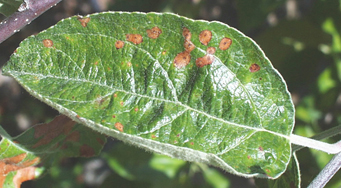

In [16]:
for idx, url in enumerate(image_urls):
    print(f'url_image_{idx}')
    display(Image.open(requests.get(url, stream=True).raw))

To encode these images in a way that is digestible for the LLM, we will be encoding the images to bytes that we then decode to UTF-8 representation.

In [10]:
encoded_images = []

for url in image_urls:
    encoded_images.append(base64.b64encode(requests.get(url).content).decode("utf-8"))

## Step 5. Set up the API request and LLM

Now that our images can be passed to the LLM, let's set up a function for our watsonx API calls. The `augment_api_request_body` function takes the user query and image as parameters and augments the body of the API request. We will use this function in each iteration.

In [11]:
def augment_api_request_body(user_query, image):
    messages = [
        {
            "role": "user",
            "content": [{
                "type": "text",
                "text": (
                    "You are an intelligent vision-based assistant specialized in agricultural diagnostics and guidance. "
                    "Your task is to analyze the provided plant image, which may depict a healthy, diseased, or abnormal plant. "
                    "Provide an accurate, concise response in 1–2 sentences to address the user's query: " + user_query
                )
            },
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{image}",
                }
            }]
        }
    ]
    return messages


Let's instantiate the model interface using the `ModelInference` class. In this tutorial, we will use the the `mistralai/pixtral-12b` model.

In [12]:
model = ModelInference(
    model_id="meta-llama/llama-3-2-11b-vision-instruct",
    credentials=credentials,
    project_id=WATSONX_EU_PROJECT_ID,
    params={
        "max_tokens": 100
      }
)
#    model_id="meta-llama/llama-3-2-90b-vision-instruct",


In [13]:
for i in range(len(encoded_images)):
	image = encoded_images[i]

	user_query = "Is this plant healthy? If not then what disease is this plant having?"

	messages = augment_api_request_body(user_query, image)

	response = model.chat(messages=messages)

	print(response['choices'][0]['message']['content'])

Failure during chat. (POST https://us-south.ml.cloud.ibm.com/ml/v1/text/chat?version=2025-01-10)
Status code: 403, body: {"errors":[{"code":"token_quota_reached","message":"Request of 1 token(s) from quota was rejected","more_info":"https://cloud.ibm.com/apidocs/watsonx-ai"}],"trace":"309c62124ad48577c97d1c600db4903e","status_code":403}


ApiRequestFailure: Failure during chat. (POST https://us-south.ml.cloud.ibm.com/ml/v1/text/chat?version=2025-01-10)
Status code: 403, body: {"errors":[{"code":"token_quota_reached","message":"Request of 1 token(s) from quota was rejected","more_info":"https://cloud.ibm.com/apidocs/watsonx-ai"}],"trace":"309c62124ad48577c97d1c600db4903e","status_code":403}

In [55]:
# image = encoded_images[0]

# user_query = "what are the treatment plans for this?"

# messages = augment_api_request_body(user_query, image)

# response = model.chat(messages=messages)

# print(response['choices'][0]['message']['content'])

The model correctly identified the object in the woman's hand. Now, let's inquire about the issue in the image of the car covered in snow.